In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import segyio
import glob

import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *

# EXPERIMENT PARAMS
from pyfrac.hydrafrac.acquisition import recgeom,rec2das_datatrnsfrm,dasgeom

# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.imaging.kirchhoff import Kirchhoff
from pyfrac.utils.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage, wiggleplot, multiwiggleplot
from pyfrac.visualisation.eventimages import locimage3d
from pyfrac.visualisation.plotting_support import explode_volume

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
datadir = './StylolitesData'
glob.glob(datadir+'/*.npz')

['./StylolitesData/StylolitesExp_1mm_5r_3sty_80perc.npz',
 './StylolitesData/StylolitesExp_3StyRndThickRoughness10.npz',
 './StylolitesData/StylolitesExp_3StyRndThickRoughness5.npz',
 './StylolitesData/StylolitesExp_3styRoughness5.npz',
 './StylolitesData/StylolitesExp_3StyRoughness1.npz',
 './StylolitesData/StylolitesExp_Clean.npz',
 './StylolitesData/StylolitesExp_3mm_5r_3sty_80perc.npz',
 './StylolitesData/StylolitesExp_2mm_5r_3sty.npz',
 './StylolitesData/StylolitesExp_1mm_5r_3sty.npz',
 './StylolitesData/StylolitesExp_2mm_5r_3sty_80perc.npz']

# MODELS

In [4]:
clean_data = np.load(os.path.join(datadir,'StylolitesExp_Clean.npz'))
clean_vp = clean_data['vp_mod']
nx,ny,nz = clean_vp.shape

In [5]:
nbounds = abs_bounds = 30 # boundary points

dx = dy = dz = 0.001  # 5mm
dimlims = 0.4 + 2*(abs_bounds*dx) # 40cm cubed
nx = ny = nz = int(dimlims/dx) 

# 1mm model
projpath = '/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/FDModelling/StylolitesTest_pointrecs_v80_1mm'
expname = 'StylolitesTest_pointrecs_v80_1mm'
mod_path = os.path.join(projpath,'inputs/model/')
vp_1mm = np.fromfile(os.path.join(mod_path,'%s.vp'%expname), dtype='<f').reshape([nz, nx, ny])[nbounds:-nbounds,nbounds:-nbounds,nbounds:-nbounds]


# 2mm model
projpath = '/home/birniece/Documents/Projects/MicroseismicModelling/MicroseismicProcessing/FDModelling/StylolitesTest_pointrecs_v80_2mm'
expname = 'StylolitesTest_pointrecs_v80_1mm'
mod_path = os.path.join(projpath,'inputs/model/')
vp_2mm = np.fromfile(os.path.join(mod_path,'%s.vp'%expname), dtype='<f').reshape([nz, nx, ny])[nbounds:-nbounds,nbounds:-nbounds,nbounds:-nbounds]


In [6]:
np.min(vp_1mm)

4208.0

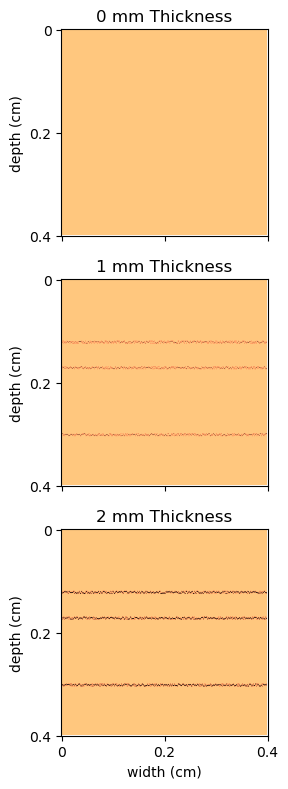

In [7]:
fig,axs = plt.subplots(3,1,figsize=[4,8],sharey=True, sharex=True)
axs[0].imshow(clean_vp[0], cmap='copper', vmin=np.min(vp_2mm), vmax=np.max(vp_2mm))
axs[1].imshow(vp_1mm[0],  cmap='copper', vmin=np.min(vp_2mm), vmax=np.max(vp_2mm))
axs[2].imshow(vp_2mm[0],  cmap='copper', vmin=np.min(vp_2mm), vmax=np.max(vp_2mm))
for ax in axs:ax.set_xticks([0,200,400],labels=[0,0.2,0.4]);
for ax in axs:ax.set_yticks([0,200,400],labels=[0,0.2,0.4]); ax.set_ylabel('depth (cm)')
axs[2].set_xlabel('width (cm)')
axs[0].set_title('0 mm Thickness')
axs[1].set_title('1 mm Thickness')
axs[2].set_title('2 mm Thickness')
plt.tight_layout()

In [8]:
# p-snaps
clean_snaps = clean_data['p_snaps']
mm1_snaps = np.load(os.path.join(datadir,'StylolitesExp_1mm_5r_3sty_80perc.npz'))['p_snaps']
mm2_snaps = np.load(os.path.join(datadir,'StylolitesExp_2mm_5r_3sty_80perc.npz'))['p_snaps']

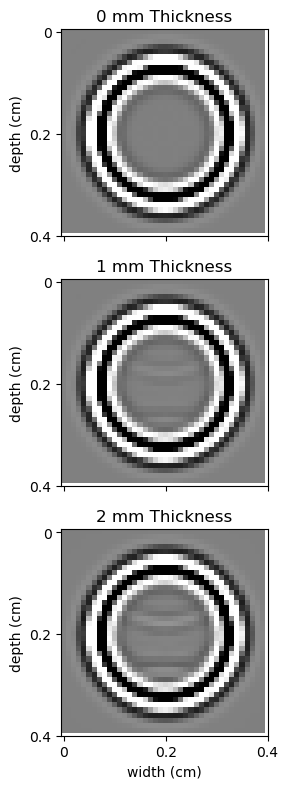

In [9]:
fig,axs = plt.subplots(3,1,figsize=[4,8],sharey=True, sharex=True)
axs[0].imshow(clean_snaps[90,:,20].T, cmap='binary', vmin=-10000, vmax=10000)
axs[1].imshow(mm1_snaps[90,:,20].T,  cmap='binary', vmin=-10000, vmax=10000)
axs[2].imshow(mm2_snaps[90,:,20].T,  cmap='binary', vmin=-10000, vmax=10000)
for ax in axs:ax.set_xticks([0,20,40],labels=[0,0.2,0.4]); 
for ax in axs:ax.set_yticks([0,20,40],labels=[0,0.2,0.4]); ax.set_ylabel('depth (cm)')
axs[2].set_xlabel('width (cm)')
axs[0].set_title('0 mm Thickness')
axs[1].set_title('1 mm Thickness')
axs[2].set_title('2 mm Thickness')
plt.tight_layout()

# WAVEFORMS

In [10]:
npzfile = 'StylolitesExp_Clean.npz'

clean_vx = np.load(os.path.join(datadir,npzfile))['vx']
clean_vy = np.load(os.path.join(datadir,npzfile))['vy']
clean_vz = np.load(os.path.join(datadir,npzfile))['vz']
clean_div = np.load(os.path.join(datadir,npzfile))['p']

clean_perp = np.zeros_like(clean_vx)
clean_perp[:25]    = -1*clean_vx[:25]
clean_perp[25:50]  =    clean_vx[25:50]
clean_perp[50:100] = -1*clean_vy[50:100]
clean_perp[75:100] =    clean_vy[75:100]
clean_perp[-50:]   = -1*clean_vz[-50:]
clean_perp[-25:]   =    clean_vz[-25:]

In [11]:
npzfile = 'StylolitesExp_1mm_5r_3sty.npz'

mm1_vx = np.load(os.path.join(datadir,npzfile))['vx']
mm1_vy = np.load(os.path.join(datadir,npzfile))['vy']
mm1_vz = np.load(os.path.join(datadir,npzfile))['vz']
mm1_div = np.load(os.path.join(datadir,npzfile))['p']

mm1_perp = np.zeros_like(mm1_vx)
mm1_perp[:25]    = -1*mm1_vx[:25]
mm1_perp[25:50]  =    mm1_vx[25:50]
mm1_perp[50:100] = -1*mm1_vy[50:100]
mm1_perp[75:100] =    mm1_vy[75:100]
mm1_perp[-50:]   = -1*mm1_vz[-50:]
mm1_perp[-25:]   =    mm1_vz[-25:]

In [12]:
npzfile = 'StylolitesExp_2mm_5r_3sty_80perc.npz'

mm2_vx = np.load(os.path.join(datadir,npzfile))['vx']
mm2_vy = np.load(os.path.join(datadir,npzfile))['vy']
mm2_vz = np.load(os.path.join(datadir,npzfile))['vz']
mm2_div = np.load(os.path.join(datadir,npzfile))['p']

mm2_perp = np.zeros_like(mm2_vx)
mm2_perp[:25]    = -1*mm2_vx[:25]
mm2_perp[25:50]  =    mm2_vx[25:50]
mm2_perp[50:100] = -1*mm2_vy[50:100]
mm2_perp[75:100] =    mm2_vy[75:100]
mm2_perp[-50:]   = -1*mm2_vz[-50:]
mm2_perp[-25:]   =    mm2_vz[-25:]

In [13]:
npzfile = 'StylolitesExp_3mm_5r_3sty_80perc.npz'

mm3_vx = np.load(os.path.join(datadir,npzfile))['vx']
mm3_vy = np.load(os.path.join(datadir,npzfile))['vy']
mm3_vz = np.load(os.path.join(datadir,npzfile))['vz']
mm3_div = np.load(os.path.join(datadir,npzfile))['p']

mm3_perp = np.zeros_like(mm3_vx)
mm3_perp[:25]    = -1*mm3_vx[:25]
mm3_perp[25:50]  =    mm3_vx[25:50]
mm3_perp[50:100] = -1*mm3_vy[50:100]
mm3_perp[75:100] =    mm3_vy[75:100]
mm3_perp[-50:]   = -1*mm3_vz[-50:]
mm3_perp[-25:]   =    mm3_vz[-25:]

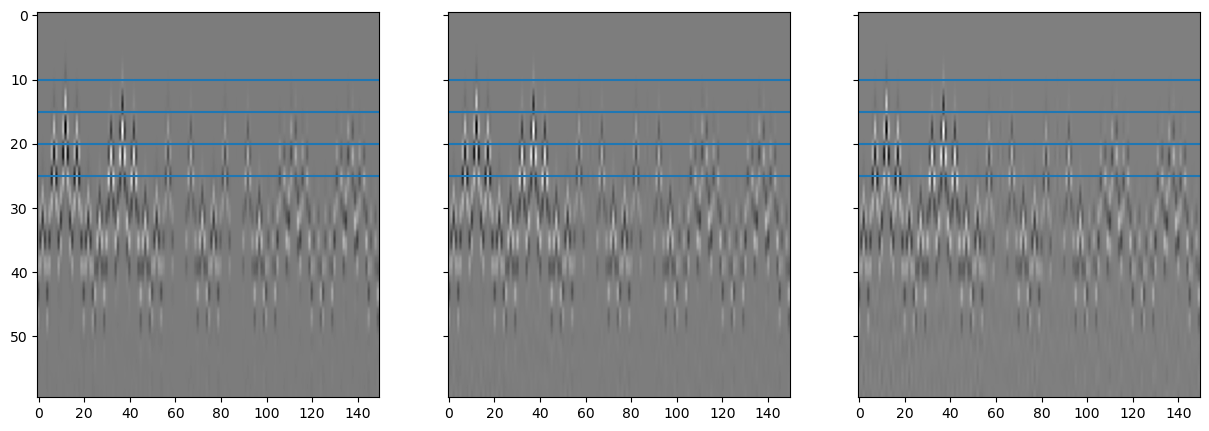

In [14]:
fig,axs = plt.subplots(1,3,figsize=[15,5], sharey=True)
axs[0].imshow(clean_vx[:,40:100].T, aspect='auto',cmap='binary_r')
axs[1].imshow(mm1_vx[:,40:100].T, aspect='auto',cmap='binary_r')
axs[2].imshow(mm2_vx[:,40:100].T, aspect='auto',cmap='binary_r')
for ax in axs: ax.axhline(10)
for ax in axs: ax.axhline(15)
for ax in axs: ax.axhline(20)
for ax in axs: ax.axhline(25)
    
    
    

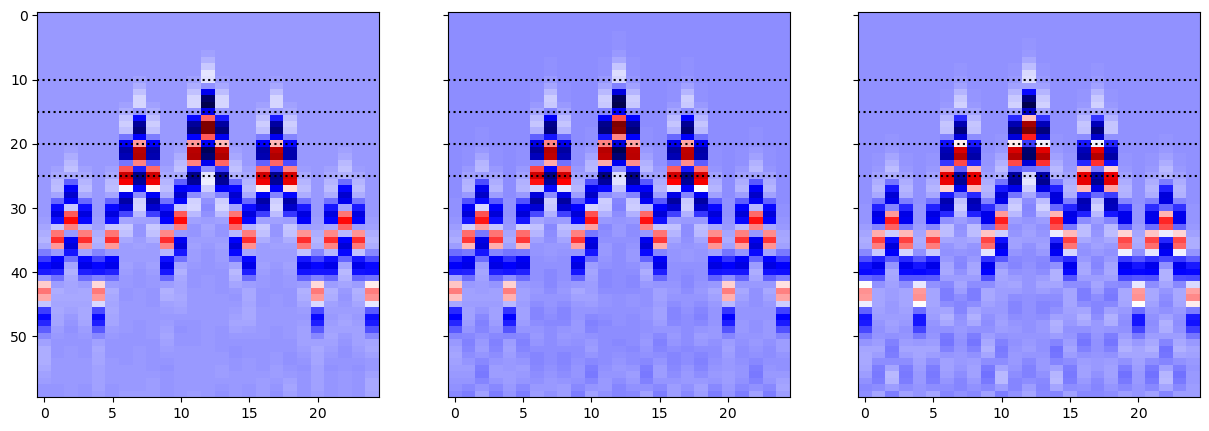

In [15]:
fig,axs = plt.subplots(1,3,figsize=[15,5], sharey=True)
axs[0].imshow(clean_perp[:25,40:100].T, aspect='auto',cmap='seismic')
axs[1].imshow(mm1_perp[:25,40:100].T, aspect='auto',cmap='seismic')
axs[2].imshow(mm2_perp[:25,40:100].T, aspect='auto',cmap='seismic')
for ax in axs: ax.axhline(10, c='k', ls=':')
for ax in axs: ax.axhline(15, c='k', ls=':')
for ax in axs: ax.axhline(20, c='k', ls=':')
for ax in axs: ax.axhline(25, c='k', ls=':')

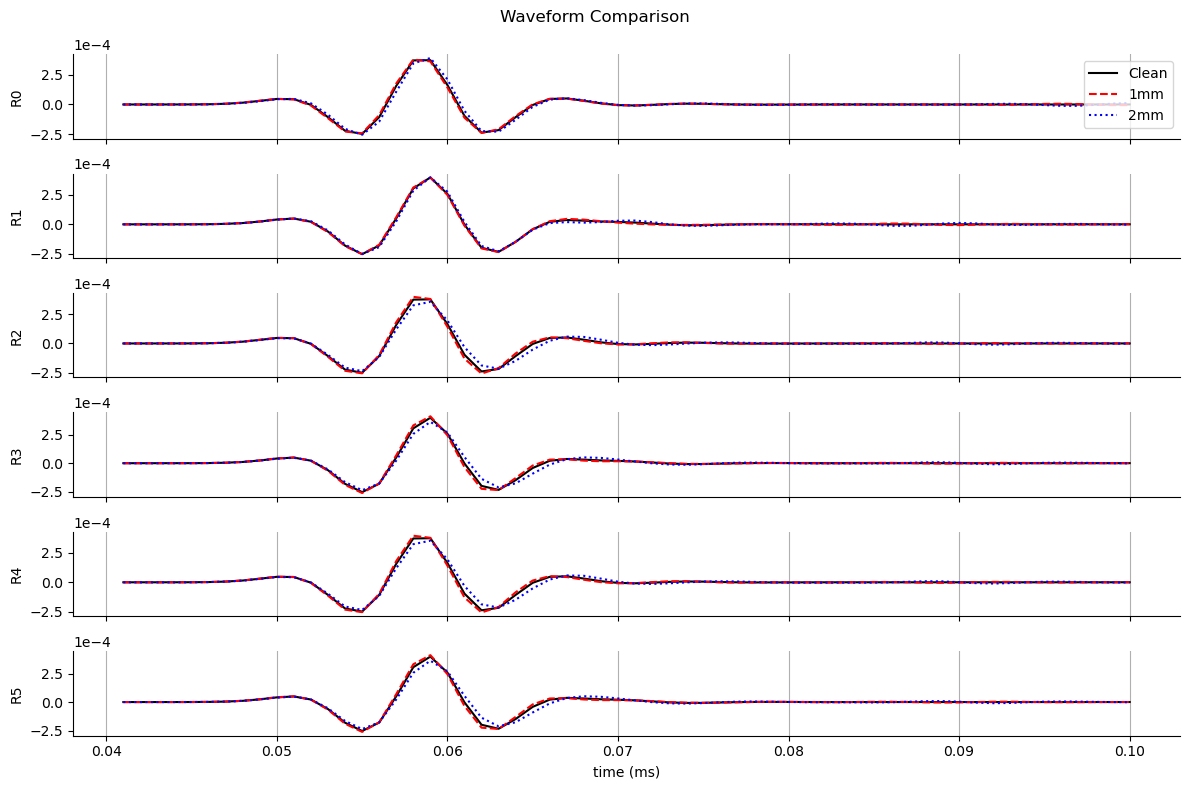

In [16]:
dt=1e-6
t = 1000* np.arange(dt,dt*len(clean_vx[0]),step=dt)
ti,tf = 40,100

datalist = [clean_perp[12::25,ti:tf], mm1_perp[12::25,ti:tf], mm2_perp[12::25,ti:tf]]
taxis = t[ti:tf]


fig, axs = plt.subplots(6, 1, figsize=[12,8], sharex=True)
clist  = ['k','r','b']
lslist = ['-','--',':']
clabel = ['Clean','1mm','2mm']

for i, ax in enumerate(axs):
    for ci,data in enumerate(datalist):
        ax.plot(taxis, data[i],
                ls=lslist[ci], c=clist[ci], label=clabel[ci]);
# for ax in axs:
    ax.set_xlim([taxis[0], taxis[-1]]);
    ax.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
    ax.grid(axis="x")
#     if norm_indiv: ax.set_ylim([-1, 1]);
# #     if xhline: ax.hlines(0, 0, len(data[0]), color='gray', linestyles=':')
#     ax.set_xticks(np.arange(len(data[0])));
#     ax.set_yticks([]);
    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
#     ax.spines['bottom'].set_visible(False);
    ax.axis('tight')
axs[-1].set_xlabel('time (ms)')
axs[0].legend(loc='upper right')
for i,ax in enumerate(axs): ax.set_ylabel('R%i'%i)
    
fig.suptitle('Waveform Comparison')
fig.tight_layout()

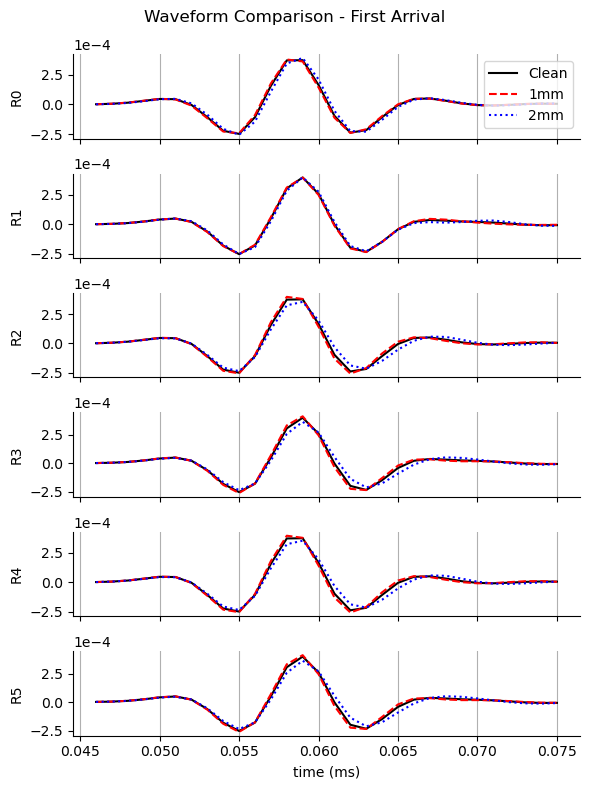

In [17]:
dt=1e-6
t = 1000* np.arange(dt,dt*len(clean_vx[0]),step=dt)
ti,tf = 45,75

datalist = [clean_perp[12::25,ti:tf], mm1_perp[12::25,ti:tf], mm2_perp[12::25,ti:tf]]
taxis = t[ti:tf]


fig, axs = plt.subplots(6, 1, figsize=[6,8], sharex=True)
clist  = ['k','r','b']
lslist = ['-','--',':']
clabel = ['Clean','1mm','2mm']

for i, ax in enumerate(axs):
    for ci,data in enumerate(datalist):
        ax.plot(taxis, data[i],
                ls=lslist[ci], c=clist[ci], label=clabel[ci]);
# for ax in axs:
    ax.set_xlim([taxis[0], taxis[-1]]);
    ax.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
    ax.grid(axis="x")
#     if norm_indiv: ax.set_ylim([-1, 1]);
# #     if xhline: ax.hlines(0, 0, len(data[0]), color='gray', linestyles=':')
#     ax.set_xticks(np.arange(len(data[0])));
#     ax.set_yticks([]);
    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
#     ax.spines['bottom'].set_visible(False);
    ax.axis('tight')
axs[-1].set_xlabel('time (ms)')
axs[0].legend(loc='upper right')
for i,ax in enumerate(axs): ax.set_ylabel('R%i'%i)
    
fig.suptitle('Waveform Comparison - First Arrival')
fig.tight_layout()

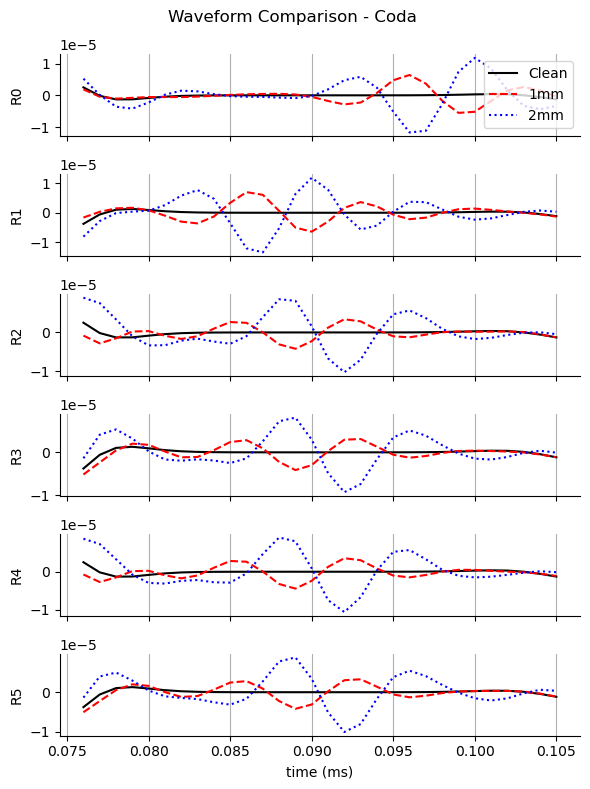

In [18]:
dt=1e-6
t = 1000* np.arange(dt,dt*len(clean_vx[0]),step=dt)

ti,tf = 75,105

datalist = [clean_perp[12::25,ti:tf], mm1_perp[12::25,ti:tf], mm2_perp[12::25,ti:tf]]
taxis = t[ti:tf]


fig, axs = plt.subplots(6, 1, figsize=[6,8], sharex=True)
clist  = ['k','r','b']
lslist = ['-','--',':']
clabel = ['Clean','1mm','2mm']

for i, ax in enumerate(axs):
    for ci,data in enumerate(datalist):
        ax.plot(taxis, data[i] , 
                ls=lslist[ci], c=clist[ci], label=clabel[ci]);        
    ax.set_xlim([taxis[0], taxis[-1]]);
    ax.grid(axis="x")
#     ax.set_yticks([]);
    ax.spines['top'].set_visible(False);
    ax.spines['right'].set_visible(False);
#     ax.spines['bottom'].set_visible(False);
    ax.axis('tight')
axs[-1].set_xlabel('time (ms)')
axs[0].legend(loc='upper right')
for i,ax in enumerate(axs): ax.set_ylabel('R%i'%i)
    
fig.suptitle('Waveform Comparison - Coda ')
fig.tight_layout()

In [19]:
# Find First Breaks
fblim = 1e-8
fb_locs_cl = np.zeros([150])
fb_locs_1mm = np.zeros([150])
fb_locs_2mm = np.zeros([150])
fb_locs_3mm = np.zeros([150])
for tr in range(150):
    fb_locs_cl[tr] = [n for n,i in enumerate(clean_perp[tr]) if abs(i)>fblim][0]
    fb_locs_1mm[tr] = [n for n,i in enumerate(mm1_perp[tr]) if abs(i)>fblim][0]
    fb_locs_2mm[tr] = [n for n,i in enumerate(mm2_perp[tr]) if abs(i)>fblim][0]
    fb_locs_3mm[tr] = [n for n,i in enumerate(mm3_perp[tr]) if abs(i)>fblim][0]

# First Break times

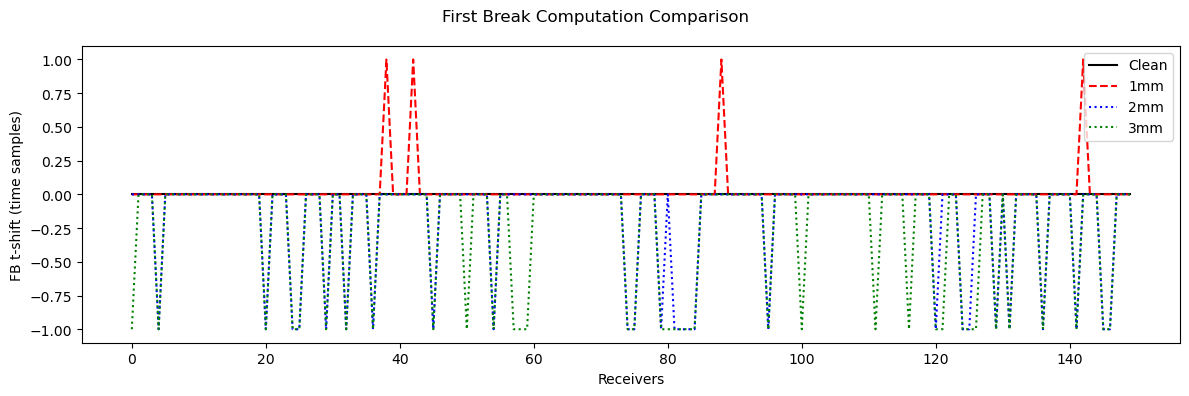

In [28]:
# plt.plot(fb_locs_cl)
# plt.plot(fb_locs_1mm)
# plt.plot(fb_locs_2mm)

fig, ax = plt.subplots(1, 1, figsize=[12,4])
fb_datalist = [fb_locs_cl, fb_locs_1mm, fb_locs_2mm, fb_locs_3mm]
clist  = ['k','r','b','g']
lslist = ['-','--',':',':']
clabel = ['Clean','1mm','2mm','3mm']

for ci,data in enumerate(fb_datalist):
    ax.plot(range(150), fb_locs_cl-data , ls=lslist[ci], c=clist[ci], label=clabel[ci]);    

ax.legend(loc='upper right')
ax.set_ylabel('FB t-shift (time samples)')    
ax.set_xlabel('Receivers')
    
fig.suptitle('First Break Computation Comparison')
fig.tight_layout()

In [ ]:
data

In [ ]:
wavelength = 35
fig,axs=plt.subplots(1,1)
plt.plot(clean_perp[0])
axs.axvline(fb_locs_cl[0],c='k', ls=':')
axs.axvline(fb_locs_cl[0]+wavelength,c='k', ls=':')

In [ ]:
np.mean(fb_energy[0])

In [23]:
wavelength = 32

fb_energy = np.zeros([4,150])
coda_energy = np.zeros([4,150])

for tr in range(150):
    fb_energy[0,tr] = np.sum(clean_perp[tr,int(fb_locs_cl[tr]):int(fb_locs_cl[tr])+wavelength]**2)
    fb_energy[1,tr] = np.sum(mm1_perp[tr,int(fb_locs_1mm[tr]):int(fb_locs_1mm[tr])+wavelength]**2)
    fb_energy[2,tr] = np.sum(mm2_perp[tr,int(fb_locs_2mm[tr]):int(fb_locs_2mm[tr])+wavelength]**2)
    fb_energy[3,tr] = np.sum(mm3_perp[tr,int(fb_locs_3mm[tr]):int(fb_locs_3mm[tr])+wavelength]**2)
    
    coda_energy[0,tr] = np.sum(clean_perp[tr,int(fb_locs_cl[tr])+wavelength:]**2)
    coda_energy[1,tr] = np.sum(mm1_perp[tr,int(fb_locs_1mm[tr])+wavelength:]**2)
    coda_energy[2,tr] = np.sum(mm2_perp[tr,int(fb_locs_2mm[tr])+wavelength:]**2)
    coda_energy[3,tr] = np.sum(mm3_perp[tr,int(fb_locs_3mm[tr])+wavelength:]**2)
    


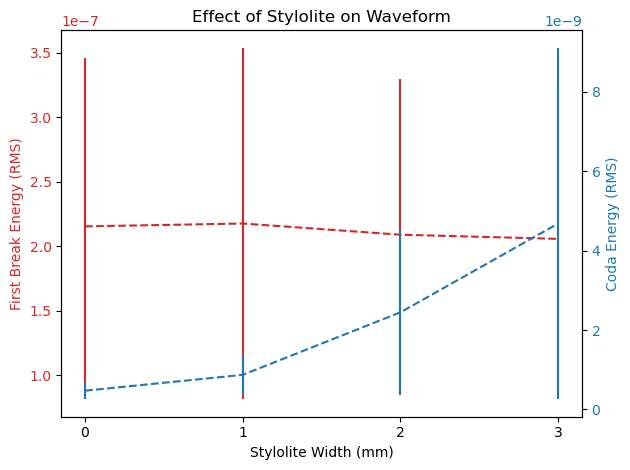

In [25]:
t = range(4)

fig, ax1 = plt.subplots()
ax1.set_xticks([0,1,2,3],labels=[0,1,2,3])
ax1.set_xlabel('Stylolite Width (mm)')

color = 'tab:red'
ax1.set_ylabel('First Break Energy (RMS)', color=color)
ax1.errorbar(t, np.mean(fb_energy,axis=1), yerr=np.std(fb_energy,axis=1),
             ls='--', color=color)
# ax1.plot(t, np.mean(fb_energy,axis=1), '--v', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.errorbar(t, np.mean(coda_energy,axis=1), yerr=np.std(coda_energy,axis=1),
             ls='--', color=color)
ax2.set_ylabel('Coda Energy (RMS)', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, np.mean(coda_energy,axis=1), '--o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Effect of Stylolite on Waveform')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

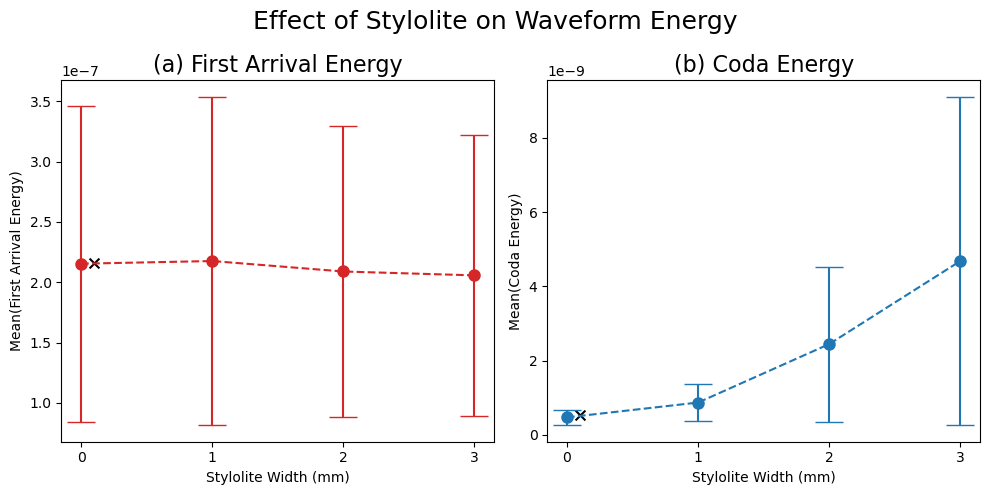

In [45]:
t = range(4)

fig, axs = plt.subplots(1,2,figsize=[10,5])

for ax in axs: ax.set_xticks([0,1,2,3],labels=[0,1,2,3]); ax.set_xlabel('Stylolite Width (mm)')

color = 'tab:red'
axs[0].set_title('(a) First Arrival Energy', fontsize=16)
axs[0].set_ylabel('Mean(First Arrival Energy)')
axs[0].errorbar(t, np.mean(fb_energy,axis=1), yerr=np.std(fb_energy,axis=1),
             ls='--', color=color, fmt='o', markersize=8, capsize=10)
axs[0].scatter(0.1,21.6e-8,marker='x',c='k', s=50)

color = 'tab:blue'
axs[1].errorbar(t, np.mean(coda_energy,axis=1), yerr=np.std(coda_energy,axis=1),
             ls='--', color=color, fmt='o', markersize=8, capsize=10)
axs[1].scatter(0.1,5.4e-10,marker='x',c='k', s=50)
axs[1].set_title('(b) Coda Energy', fontsize=16)
axs[1].set_ylabel('Mean(Coda Energy)')

plt.suptitle('Effect of Stylolite on Waveform Energy', fontsize=18)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()